# Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.optimizers import SGD
from keras.layers import Dense

from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time

# Importing Data

In [2]:
data = pd.read_csv('../input/thesis/dumy100000.csv')

# MCDM

# VIKOR

10.56 % -> A: 10558
18.73 % -> B: 18732
70.71 % -> C: 70710
Total:  100000


,mfg,sell,demand,fcost,rma,qi,RunCumCost,RunCostPerc,Rank,RunItemCum,RunItemPerc,Class
0,71,156.91,1595,49.7,3,0.383965,36257.514659,76.779078,59291.0,1.757741e+09,35.154468,C
1,474,1047.54,6877,331.8,3,0.901189,1962.408386,4.155605,2101.0,2.208151e+06,0.044163,C
2,70,154.70,5182,49.0,3,0.683190,16176.765170,34.255992,20391.0,2.079066e+08,4.158091,C
3,417,921.57,3914,291.9,3,0.473220,29837.401955,63.183818,44227.0,9.780359e+08,19.560522,C
4,239,528.19,4496,167.3,2,0.449204,31487.105629,66.677238,47806.0,1.142731e+09,22.854386,C


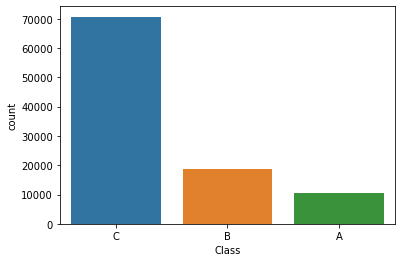

In [3]:
dn = 0
dn = data.copy()
del dn['Unnamed: 0']
d1 = dn.copy()

d2 = pd.DataFrame(columns = d1.columns)
d2 = d2.T
d2["max"] = 0
d2["min"] = 0
d2 = d2.T

for i in range(len(d2.columns)):
    d2.iloc[0,i] = d1.iloc[:,i].max()
    d2.iloc[1,i] = d1.iloc[:,i].min()

# max-min normalizer = 0
# linear normalizer = 1
normalizer = 0

if normalizer == 0 :
    for i in range(len(d1.columns)):
        if i==0 or i==3: #Non Beneficial
            d1.iloc[:,i] = (d2.iloc[0,i]-d1.iloc[:,i])/(d2.iloc[0,i] - d2.iloc[1,i])

        else: #Beneficial
            d1.iloc[:,i] = (d1.iloc[:,i]-d2.iloc[1,i])/(d2.iloc[0,i] - d2.iloc[1,i])

else:
    for i in range(len(d1.columns)):
        if i==0 or i==3: #Non Beneficial
            d1.iloc[:,i] = d2.iloc[1,i]/d1.iloc[:,i]

        else: #Beneficial
            d1.iloc[:,i] = d1.iloc[:,i]/ d2.iloc[0,i]

w  = [0.15, 0.20, 0.30, 0.15, 0.20]
d1 = d1*w

d1['si'] = d1.iloc[:].sum(axis=1)

d1['ri'] = d1.iloc[:,0:-2].max(axis=1)

s_best  = d1['si'].min()
s_worst = d1['si'].max()
r_best  = d1['ri'].min()
r_worst = d1['ri'].max()
neu = 0.5

d1['qi'] = d1.apply(lambda row: neu*((row.si-s_best)/(s_worst-s_best))+(1-neu)*((row.ri-r_best)/(r_worst-r_best)) , axis =1 )

dn['qi'] = d1['qi']

dn = dn.sort_values(by=['qi'], ascending=False)

dn['RunCumCost']   = dn['qi'].cumsum()
TotSum             = dn['qi'].sum()
dn['RunCostPerc']  = (dn['RunCumCost']/TotSum)*100

dn['Rank']         = dn['RunCostPerc'].rank()
dn['RunItemCum']   = dn['Rank'].cumsum()
TotItemSum         = dn['Rank'].sum()
dn['RunItemPerc']  = (dn['RunItemCum']/TotItemSum)*100

def ABC_segmentation(perc):
    '''
    top A - top 20%, C - last 50% and B - between A & C
    
    '''
    if perc > 80 :
        return 'A'
    elif perc >= 50 and perc <= 80:
        return 'B'
    elif perc < 50:
        return 'C'

dn['Class'] = dn['RunItemPerc'].apply(ABC_segmentation)

ax = sns.countplot(x = dn['Class'],data = dn,label= 'Count')
dn['Class'].value_counts()

dn['productid'] = dn.index
dn = dn.sort_values(by=['productid'], ascending=True)
del dn['productid']
VIKOR_Class = dn['Class']

C,B,A = dn['Class'].value_counts()
print(round(100*A/dn['Class'].value_counts().sum(),2),"% ->","A:",A)
print(round(100*B/dn['Class'].value_counts().sum(),2),"% ->","B:",B)
print(round(100*C/dn['Class'].value_counts().sum(),2),"% ->","C:",C)
print("Total: ",dn['Class'].value_counts().sum())
dn.head()

# Machine Learning

In [4]:
iteration = 5
row_col = np.zeros([iteration,])

acc = pd.DataFrame()
acc['train_Acc'] = row_col
acc['test_Acc']  = row_col
acc['time']      = row_col
acc['test_size'] = row_col
start_time  = 0
end_time    = 0
train_score = 0
test_score  = 0

#split_size 
n = .1

# ANN

In [5]:
for i in range(iteration):
      
    X = dn.iloc[:,0:5].astype('float32')
    y = dn['Class'] #.iloc[0:100,-1] 

    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)

    y = to_categorical(y)

    X_train,X_test,y_train,y_test = train_test_split(X, y ,test_size = n, random_state=0)
    X_train,X_val,y_train,y_val = train_test_split(X_train, y_train ,test_size = n, random_state=0)

    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test  = sc.fit_transform(X_test)
    X_val  = sc.fit_transform(X_val)
           
    #time start
    start_time = time.time()
    
    model = Sequential()
    model.add(Dense(5, activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dense(3, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train,y_train,batch_size = 128, epochs = 20, validation_data = (X_val,y_val))

    #time end
    end_time = time.time()
        
    train_score = model.evaluate(X_train,y_train,verbose=0)
    test_score = model.evaluate(X_test,y_test,verbose=0)
       
    #time calculation 
    acc.iloc[i,2] = end_time - start_time
    
    #Accuracy
    acc.iloc[i,0] = train_score[1]*100
    acc.iloc[i,1] = train_score[1]*100
    
    #test size
    acc.iloc[i,3] = n*100
    
    if n == .1:
        n = .2
    else :
        n = .1

Epoch 1/20
633/633 [==============================] - 2s 2ms/step - loss: 1.0209 - accuracy: 0.6256 - val_loss: 0.7108 - val_accuracy: 0.8104
Epoch 2/20
633/633 [==============================] - 1s 1ms/step - loss: 0.6138 - accuracy: 0.8121 - val_loss: 0.4350 - val_accuracy: 0.8699
Epoch 3/20
633/633 [==============================] - 1s 1ms/step - loss: 0.4056 - accuracy: 0.8741 - val_loss: 0.3378 - val_accuracy: 0.9120
Epoch 4/20
633/633 [==============================] - 1s 1ms/step - loss: 0.3225 - accuracy: 0.9158 - val_loss: 0.2827 - val_accuracy: 0.9413
Epoch 5/20
633/633 [==============================] - 1s 1ms/step - loss: 0.2719 - accuracy: 0.9421 - val_loss: 0.2448 - val_accuracy: 0.9486
Epoch 6/20
633/633 [==============================] - 1s 1ms/step - loss: 0.2371 - accuracy: 0.9522 - val_loss: 0.2171 - val_accuracy: 0.9506
Epoch 7/20
633/633 [==============================] - 1s 1ms/step - loss: 0.2119 - accuracy: 0.9535 - val_loss: 0.1937 - val_accuracy: 0.9550
Epoch 

In [6]:
acc = acc.round(2)
acc

,train_Acc,test_Acc,time,test_size
0,98.67,98.67,18.15,10.0
1,97.79,97.79,14.77,20.0
2,97.56,97.56,17.19,10.0
3,98.35,98.35,15.23,20.0
4,98.72,98.72,17.28,10.0


In [7]:
ANNAcc = acc.mean()
ANNAcc

train_Acc    98.218
test_Acc     98.218
time         16.524
test_size    14.000
dtype: float64

# SVM

In [8]:
n = .1
for i in range(iteration):
    
    X = dn.iloc[:,0:5].astype('float32')
    y = dn['Class']

    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = n, random_state=0)
    
    sc = StandardScaler()
    X_train = sc.fit_transform(X_train)
    X_test  = sc.fit_transform(X_test)
    
    #time start
    start_time = time.time()
    
    
    model = SVC(kernel='poly')
    model.fit(X_train,y_train)
    
    #time end
    end_time = time.time()

    train_score = model.score(X_train,y_train)
    test_score  = model.score(X_test,y_test)
    
    #time calculation 
    acc.iloc[i,2] = end_time - start_time
    
    #Accuracy
    acc.iloc[i,0] = train_score*100
    acc.iloc[i,1] = test_score*100
    
    #test size
    acc.iloc[i,3] = n*100

    if n == .1:
        n = .2
    else :
        n = .1
    print(i+1," run")

1  run
2  run
3  run
4  run
5  run


In [9]:
acc = acc.round(2)
acc

,train_Acc,test_Acc,time,test_size
0,91.96,91.99,179.31,10.0
1,91.88,92.12,121.68,20.0
2,91.96,91.99,121.11,10.0
3,91.88,92.12,203.21,20.0
4,91.96,91.99,149.56,10.0


In [10]:
SVMAcc = acc.mean()
SVMAcc

train_Acc     91.928
test_Acc      92.042
time         154.974
test_size     14.000
dtype: float64

# KNN

In [11]:
n = .1
for i in range(iteration):
    
    X = dn.iloc[:,0:5].astype('float32')
    y = dn['Class']

    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = n, random_state=0)

    
    #time start
    start_time = time.time()
        
    model = KNeighborsClassifier(n_neighbors=3)
    model.fit(X_train,y_train)
    
    #time end
    end_time = time.time()

    train_score = model.score(X_train,y_train)*100
    test_score  = model.score(X_test,y_test)*100
    
    #time calculation 
    acc.iloc[i,2] = end_time - start_time
    
    #Accuracy
    acc.iloc[i,0] = train_score
    acc.iloc[i,1] = test_score
    
    #test size
    acc.iloc[i,3] = n*100
    
    if n == .1:
        n = .2
    else :
        n = .1
    print(i+1," run")

1  run
2  run
3  run
4  run
5  run


In [12]:
acc = acc.round(2)
acc

,train_Acc,test_Acc,time,test_size
0,88.07,77.34,0.13,10.0
1,88.08,76.98,0.11,20.0
2,88.07,77.34,0.12,10.0
3,88.08,76.98,0.11,20.0
4,88.07,77.34,0.34,10.0


In [13]:
KNNAcc = acc.mean()
KNNAcc

train_Acc    88.074
test_Acc     77.196
time          0.162
test_size    14.000
dtype: float64

# GPC

In [14]:
n = .1
for i in range(iteration):
    
    X = dn.iloc[:,0:5].astype('float32')
    y = dn['Class'] #.iloc[0:100,-1]

    encoder = LabelEncoder()
    encoder.fit(y)
    y = encoder.transform(y)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = n, random_state=0)

    
    #time start
    start_time = time.time()
        
    model = GaussianProcessClassifier(multi_class='one_vs_one')
    model.fit(X_train,y_train)
    
    #time end
    end_time = time.time()

    train_score = model.score(X_train,y_train)
    test_score  = model.score(X_test,y_test)
    
    #time calculation 
    acc.iloc[i,2] = end_time - start_time
    
    #Accuracy
    acc.iloc[i,0] = train_score*100
    acc.iloc[i,1] = test_score*100
    
    #test size
    acc.iloc[i,3] = n*100

    if n == .1:
        n = .2
    else :
        n = .1
    print(i+1," run")

1  run
2  run
3  run
4  run
5  run


In [15]:
acc = acc.round(2)
acc

,train_Acc,test_Acc,time,test_size
0,100.0,73.20,98.25,10.0
1,100.0,73.75,73.01,20.0
2,100.0,73.20,96.54,10.0
3,100.0,73.75,74.31,20.0
4,100.0,73.20,99.64,10.0


In [16]:
GPCAcc = acc.mean()
GPCAcc

train_Acc    100.00
test_Acc      73.42
time          88.35
test_size     14.00
dtype: float64

In [17]:
performance = {
    "Performance" : ['Avg Train Accuracy','Avg Test Accuracy','Avg Run Time','Avg Test size'],
    "ANN"         : ANNAcc,
    "SVM"         : SVMAcc,
    "KNN"         : KNNAcc,
    "GPC"         : GPCAcc
}
Performance = pd.DataFrame(performance)
Performance

,Performance,ANN,SVM,KNN,GPC
train_Acc,Avg Train Accuracy,98.218,91.928,88.074,100.00
test_Acc,Avg Test Accuracy,98.218,92.042,77.196,73.42
time,Avg Run Time,16.524,154.974,0.162,88.35
test_size,Avg Test size,14.000,14.000,14.000,14.00


In [18]:
p1 = Performance.iloc[0:3,1:5].T
p2 = pd.DataFrame(columns = p1.columns)
p2 = p2.T
p2["max"] = 0
p2["min"] = 0
p2 = p2.T
for i in range(len(p2.columns)):
    p2.iloc[0,i] = p1.iloc[:,i].max()
    p2.iloc[1,i] = p1.iloc[:,i].min()

# max-min normalizer = 0
# linear normalizer = 1
normalizer = 0

if normalizer == 0 :
    for i in range(len(p1.columns)):
        if i==2: #Non Beneficial
            p1.iloc[:,i] = (p2.iloc[0,i]-p1.iloc[:,i])/(p2.iloc[0,i] - p2.iloc[1,i])

        else: #Beneficial
            p1.iloc[:,i] = (p1.iloc[:,i]-p2.iloc[1,i])/(p2.iloc[0,i] - p2.iloc[1,i])

else:
    for i in range(len(p1.columns)):
        if i==2: #Non Beneficial
            p1.iloc[:,i] = p2.iloc[1,i]/p1.iloc[:,i]

        else: #Beneficial
            p1.iloc[:,i] = p1.iloc[:,i]/ p2.iloc[0,i]
            
weight = [0.5,0.3,0.2]
p1 = p1*weight

p1['si'] = p1.iloc[:].sum(axis=1)

p1['ri'] = p1.iloc[:,0:-2].max(axis=1)

s_best  = p1['si'].min()
s_worst = p1['si'].max()
r_best  = p1['ri'].min()
r_worst = p1['ri'].max()
neu = 0.5

p1['p-w'] = p1.apply(lambda row: neu*((row.si-s_best)/(s_worst-s_best))+(1-neu)*((row.ri-r_best)/(r_worst-r_best)) , axis =1 )


p1 = p1.sort_values(by=['p-w'], ascending=False)
p1

,train_Acc,test_Acc,time,si,ri,p-w
ANN,0.425289,0.300000,0.178862,0.904151,0.425289,0.917777
GPC,0.500000,0.000000,0.086071,0.586071,0.500000,0.758470
SVM,0.161580,0.225284,0.000000,0.386864,0.225284,0.304867
KNN,0.000000,0.045681,0.200000,0.245681,0.045681,0.000000


In [19]:
p1.round(2)

,train_Acc,test_Acc,time,si,ri,p-w
ANN,0.43,0.30,0.18,0.90,0.43,0.92
GPC,0.50,0.00,0.09,0.59,0.50,0.76
SVM,0.16,0.23,0.00,0.39,0.23,0.30
KNN,0.00,0.05,0.20,0.25,0.05,0.00
